In [1]:
import session_config
import reports
import userdisplay
import geospatial
import gridforecast as gfcast

import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

from myst_nb import glue
from IPython.display import display, Markdown

logging.basicConfig(
    filename='app.log', 
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)

# Canton - sample


:::{dropdown} How to make a report
A report is the implementation of a `SurveyReport`, `LandUseReport` and a  `GridForecaster`. The default method for a survey-report is `discovery`. In this method the objects of interest are _discovered_ by indentifying the objects that appear often (frequence) and in abundance (highest absolute count). Often is defined as identified in 50% of the surveys. Abundance is the sum of all the counts for a particular object, the ten most _abundant_ objects are considered important.

The land-use-report accepts the `SurveyReport.sample_results` and assigns the land-use attributes to the record. The land-use-report provides the baseline assessement of litter density in reference to the surrounding environment. The assessment accepts as variables the proportion of available space that a topographical feature occupies in a circle of $\pi r² \text{ where r = 1 500 meters}$ and the center of that circle is the survey location. These proportions are compared to the `average pieces per meter` for an object or group of objects.

The GridForecaster accepts as variables the `SurveyReport.sample_results` from two reports, the prior and the likelihood. Here is where the prior and likelihood are defined for the rest of the forecasting grid. The default inference pipepline is an implementation of conditional probability using the mutlinomial-dirichlet conjugate relationship with two priors. The first prior considers all the data within the limits of the query parameters and if possible the data prior to the temporal window of the query. The second prior is wieghted according to the land-use characteristics of the data considered under the query parameters and prior to the temporal range.

Each report and the inference method are documented: [SurveyReport](surveyreporter), [LandUseReport](landusereporter), [GridForecaster](gridforecaster)

__Create a report__

A report can be intiated by providing the name of the canton. If your canton does not appear this is because we have no data. The prior dates will be calculated automatically, by taking all data prior to the start date of the querry.

```{code} python

# the dates i am interested in, the most recent sampling camapaign
observed_dates = {'start':'2020-01-01', 'end':'2021-12-31'}

# everything that was seen before
prior_dates = {'start':'2015-11-15', 'end':'2019-12-31'}

# name the canton
canton = 'Bern'

# define the dates of interest
data_of_interest = {'canton':canton, 'date_range':observed_dates}
sampling_history = {'canton':canton, 'date_range':prior_dates}

# make report
results = gridforecast.reports_and_forecast(data_of_interest, sampling_history, ldata=data, logger=logger)
```
:::



In [2]:
data = session_config.collect_survey_data()
o_dates = {'start':'2020-01-01', 'end':'2021-12-31'}
prior_dates = {'start':'2015-11-15', 'end':'2019-12-31'}

canton = 'Bern'
d= data.reset_index(drop=True)

In [3]:
# likelihood_data, l_locations, l_message = gfcast.check_params({'canton':canton, 'date_range':o_dates}, d, logger)
# prior_data, p_locations, p_message = gfcast.check_params({'canton':canton, 'date_range':prior_dates}, d, logger)
results = gfcast.reports_and_forecast({'canton':canton, 'date_range':o_dates}, {'canton':canton, 'date_range':prior_dates}, ldata=d.copy(), logger=logger)
# collect the results from the prior and the likelihood
prr = results['prior_report'].sample_results.groupby('sample_id')['pcs/m'].sum()
lkl = results['this_report'].sample_results.groupby('sample_id')['pcs/m'].sum()

# consider all values
xii = results['posterior_no_limit'].sample_posterior()

# limit to the 99th percentile
sample_values, posterior, summary_simple = gfcast.dirichlet_posterior(results['posterior_99'])

In [4]:
t = results['this_report'].inventory()
t['material'] = t.index.map(lambda x: userdisplay.code_material.loc[x, 'material'])
material_report = t.groupby(['material']).quantity.sum()
mr = material_report/sum(material_report)
mr = (mr*100).astype(int)
mr = pd.DataFrame(mr[mr > 1])
mr['% of total'] = mr.quantity.apply(lambda x: f'{x}%')
mr = mr[['% of total']].T
mr = mr.style.set_table_styles(userdisplay.table_css_styles)


In [5]:
fig, ax = plt.subplots()

o_surveys = results['this_report'].sample_results
p_surveys = results['prior_report'] .sample_results

sns.histplot(data=o_surveys, x='pcs/m', stat='probability', label='observed', ax=ax)
sns.histplot(data=p_surveys, x='pcs/m', stat='probability', label='prior',ax=ax)
ax.legend()
plt.tight_layout()
glue('prior-likelihood', fig, display=False)
plt.close()

In [6]:
fig, ax = plt.subplots()

sns.ecdfplot(prr, label='prior', ls='-', ax=ax)
sns.ecdfplot(lkl, label='observed', ls='-', ax=ax)
sns.ecdfplot(sample_values, label='expected 99%', ls=':')
sns.ecdfplot(xii, label='expected max', ls='-.')
ax.set_xlim(-.1, 10)
ax.legend()
plt.tight_layout()
glue('cumumlative-dist-forecast-prior', fig, display=False)
plt.close()

In [7]:
os = results['this_report'].object_summary()
os.reset_index(drop=False, inplace=True)

# mostcommon objects
most_common_objects, mc_codes, proportions = userdisplay.most_common(os)
most_common_objects = most_common_objects.set_caption("")

In [8]:
def display_forecast(fcast_summary):
    average = fcast_summary['average']
    hdi_min, hdi_max = fcast_summary['hdi'][0], fcast_summary['hdi'][1]
    
    range_90_min, range_90_max= fcast_summary['range'][0], fcast_summary['range'][-1]
    alist = f'\n* Average: {round(average, 2)}\n* HDI 95%: {round(hdi_min, 2)} - {round(hdi_max, 2)}\n* 90% Range: {round(range_90_min, 2)} - {round(range_90_max,2)}'
    return alist
new_list = display_forecast(summary_simple)
new_list2 = display_forecast(results['posterior_no_limit'].get_descriptive_statistics())
new_list1 = Markdown('__Given the 99th percentile of all observed samples__' + new_list)
new_list2 = Markdown('__Given the observed max__' + new_list2)


In [9]:
feature_inv = results['this_report'].feature_inventory()
feature_inv.pop('p')


feature_inventory = Markdown(userdisplay.feature_inventory(feature_inv, session_language='en'))

aboundaries = results['this_report'].administrative_boundaries().copy()
aboundaries.pop('canton')
aboundaries.pop('parent_boundary')

administrative_boundaries = Markdown(userdisplay.boundaries(aboundaries, session_language='en'))


header = userdisplay.sampling_result_summary(results['this_report'].sampling_results_summary, session_language='en')[0]
info = userdisplay.sampling_result_summary(results['this_report'].sampling_results_summary, session_language='en')[1]
samp_sum = Markdown(f'{header}\n{info}')

prior_header = userdisplay.sampling_result_summary(results['prior_report'].sampling_results_summary, session_language='en')[0]
prior_info = userdisplay.sampling_result_summary(results['prior_report'].sampling_results_summary, session_language='en')[1]
prior_samp_sum = Markdown(f'{prior_header}\n{prior_info}')

ratio_most_common = Markdown(f'The most common objects account for {int(proportions*100)}% of all objects')

# one_list = Markdown(f'{feature_inventory}\n{administrative_boundaries}')
glue('material-report', mr, display=False)
glue('forecast-weighted-prior', new_list2, display=False)
glue('forecast-all-prior', new_list1, display=False)
glue('ratio-most-common', ratio_most_common, display=False)
glue('most_common_objects', most_common_objects, display=False)
glue('prior-sampling-summary', prior_samp_sum, display=False)
glue('sampling-summary', samp_sum, display=False)
glue('feature-inventory', feature_inventory, display=False)
glue('administrative-boundaries', administrative_boundaries, display=False)


## Bern

### Vital statistics

::::{grid} 2 2 2 2
:::{grid-item}
:columns: 12 5 5 5
```{glue} feature-inventory
```
```{glue} administrative-boundaries
```
```{glue} sampling-summary
```
__Material composition__

```{glue} material-report
```
:::
:::{grid-item-card}
:columns: 12 7 7 7
```{glue} prior-likelihood
```
+++
Observed samples most recent campaign and sampling history
:::
::::

### Forecast

::::{grid} 1 1 2 2
:::{grid-item-card}

Minimum expected survey results 2025
^^^


```{glue} forecast-all-prior
```
```{glue} forecast-weighted-prior
```

:::

:::{grid-item-card}
:shadow: none
```{glue} cumumlative-dist-forecast-prior
```
+++
Cumulative distribution of observed, sampling history and forecasts using to different priors.
:::
::::

### Most common objects
::::{grid} 2 2 2 2 
:::{grid-item}
:columns: 4

The most common objects from the selected data. The most common objects are a combination of the top ten most abundant objects and those objects that are found in more than 50% of the samples. Some objects are found frequently but at low quantities.Other objects are found in fewer samples but at higher quantities.

```{glue} ratio-most-common
```
:::

:::{grid-item-card}
:columns: 8
:shadow: none

```{glue} most_common_objects
:::
::::

### Municipal Results

The average pieces per meter of the most common objects for each city.

In [10]:
dx = results['this_report'].df
dx = dx[dx.code.isin(mc_codes)]
dct = dx.groupby(['sample_id','city', 'code'], as_index=False).agg(session_config.unit_agg)
dct = dct.groupby(['city', 'code'], as_index=False).agg(session_config.agg_groups)
cities = dct.city.unique()

new_df = []
for city in cities:
    x = dct[dct.city == city][['city','code', 'pcs/m']]
    new_df.append(x)

i = pd.concat(new_df)

i['description'] = userdisplay.code_definitions(i.code)
i = i.pivot(index='description', columns='city', values='pcs/m')
hmax = userdisplay.highlight_max
ncities = len(i.columns)
i = i.style.apply(hmax, props='color: red')
i = i.highlight_max(color='yellow', axis=1)
i = i.set_table_styles(userdisplay.table_css_styles).format(precision=2)
i

city,Beatenberg,Bern,Biel/Bienne,Brienz (BE),Brügg,Burgdorf,Bönigen,Erlach,Gals,Kallnach,Köniz,Ligerz,Lüscherz,Nidau,Port,Rubigen,Spiez,Thun,Unterseen,Vinelz,Walperswil
description,,,,,,,,,,,,,,,,,,,,,
Cigarette filters,0.55,0.05,1.23,0.02,0.28,0.07,1.19,0.44,0.09,0.00,0.09,0.76,0.04,0.00,0.63,0.06,0.06,0.21,0.58,0.05,0.00
Expanded polystyrene,0.18,0.00,0.26,0.34,0.00,0.00,0.07,0.02,0.00,0.14,0.00,0.06,0.00,0.04,0.00,0.00,0.11,0.11,0.11,0.10,0.00
Foam packaging/insulation/polyurethane,0.42,0.00,0.09,0.03,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.01,0.00,0.01,0.00,0.11,0.03,0.19
"Food wrappers; candy, snacks",0.12,0.01,0.39,0.44,0.00,0.02,0.06,0.05,0.12,0.08,0.00,0.78,0.02,0.60,0.07,0.11,0.02,0.10,0.11,0.28,0.00
Fragmented plastics,0.44,0.02,0.62,0.40,0.03,0.02,1.01,0.49,0.28,0.12,0.00,1.94,0.12,0.64,0.22,0.00,0.09,0.23,0.23,1.18,0.00
"Glass drink bottles, pieces",0.02,0.01,0.16,0.01,0.36,0.00,0.00,0.02,0.07,0.00,0.00,1.00,0.12,0.12,0.01,0.00,0.14,0.03,0.03,0.20,0.00
Industrial pellets (nurdles),0.03,0.00,0.06,0.60,0.00,0.00,0.04,0.00,0.00,0.10,0.00,0.00,0.01,0.08,0.01,0.00,0.00,0.00,0.00,0.13,0.00
Industrial sheeting,0.03,0.03,0.26,0.72,0.00,0.22,0.15,0.00,0.03,0.32,0.00,1.19,0.05,0.40,0.00,0.00,0.03,0.21,0.16,0.61,0.00
Packaging films nonfood or unknown,0.04,0.00,0.13,0.05,0.00,0.11,0.00,0.02,0.00,0.01,0.00,0.88,0.01,0.24,0.04,0.00,0.00,0.03,0.05,0.19,0.00


### Land use profile

The proportion of samples by the magnitude of the land-use and and the average pieces per meter for that land use configuration

#### Sampling profile

In [11]:
g = results['this_land_use'].n_samples_per_feature().copy()
userdisplay.landuse_profile(g[session_config.feature_variables[:-1]], nsamples=len(lkl))

,0 - 20%,20 - 40%,40 - 60%,60 - 80%,80 - 100%
Orchards,100%,0%,0%,0%,0%
Vineyards,100%,0%,0%,0%,0%
Buildings,30%,31%,26%,10%,2%
Forest,27%,64%,9%,0%,0%
Undefined,35%,12%,36%,17%,0%
Public Services,98%,2%,0%,0%,0%


#### Average pieces per meter

In [12]:
gt = results['this_land_use'].rate_per_feature().copy()

userdisplay.litter_rates_per_feature(gt.loc[session_config.feature_variables[:-1]])

,0 - 20%,20 - 40%,40 - 60%,60 - 80%,80 - 100%
Orchards,2.76,0.00,0.00,0.00,0.00
Vineyards,2.76,0.00,0.00,0.00,0.00
Buildings,2.37,2.52,4.09,1.59,1.24
Forest,3.02,2.86,1.27,0.00,0.00
Undefined,3.22,3.10,2.64,1.81,0.00
Public Services,2.82,0.07,0.00,0.00,0.00


### Streets and trails

The density of the road network is the length in meters of all roads and or trails designated on the map layer. No difference is made between type of road. The total number of meters for each location is normalized 0 - 1. That is locations with a less dense network will figure in the columns 0 - 20%, where the locations with the most dense road network will figure in the last column.

#### Sampling profile

In [13]:
streets = results['this_land_use'].n_samples_per_feature().copy()
streets = streets[[session_config.feature_variables[-1]]].copy()
streets = userdisplay.street_profile(streets.T, nsamples=len(lkl))
caption = ""
streets = streets.set_caption(caption)
streets

,0 - 20%,20 - 40%,40 - 60%,60 - 80%,80 - 100%
streets,42%,49%,7%,2%,0%


#### Average pieces per meter

In [14]:
streets_r = results['this_land_use'].rate_per_feature().copy()
streets_r = streets_r.loc[[session_config.feature_variables[-1]]].copy()
streets_r = userdisplay.street_profile(streets_r, nsamples=len(lkl), caption='rate')
caption = ""
streets_r = streets_r.set_caption(caption)
streets_r

,0 - 20%,20 - 40%,40 - 60%,60 - 80%,80 - 100%
streets,1.66,4.04,0.99,0.16,0.00


In [15]:
remove_locations = results['this_report'].df.location.unique()
newd = d[~d.location.isin(remove_locations)].copy()
oreport, olanduse = gfcast.make_report_objects(newd)
odata = olanduse.df_cat.copy()
weights = gfcast.land_use_weights(results['this_land_use'], session_config.feature_variables)

new_samples, new_weghts = gfcast.select_prior_data_by_feature_weight(odata, weights, session_config.feature_variables)
new_post, notes = gfcast.posterior_dirichlet_counts(lkl, new_samples['pcs/m'].values)
rt, y, s= gfcast.dirichlet_posterior(new_post)
s

{'range': array([ 0.2  ,  0.5  ,  1.2  ,  5.1  , 12.835]),
 'nsamples': 100,
 'average': 3.158000000000001,
 'hdi': (0.1, 13.5)}

### Forecast by land use

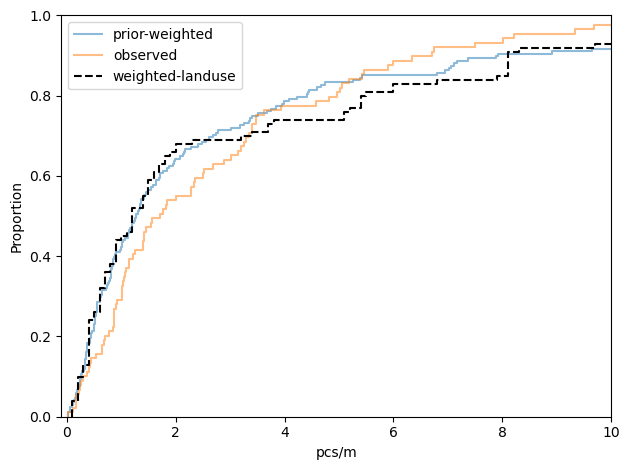

In [16]:
fig, ax = plt.subplots()

sns.ecdfplot(new_samples['pcs/m'].values, label='prior-weighted', ls='-', alpha=.5,ax=ax)
sns.ecdfplot(lkl, label='observed', ls='-', alpha=.5,ax=ax)
# sns.ecdfplot(sample_values, label='expected 99%', ls=':',alpha=.5,ax=ax)
# sns.ecdfplot(xii, label='expected max', ls='-.', alpha=.5,ax=ax)
sns.ecdfplot(rt, label='weighted-landuse', ls='--', c='black', lw=1.5)
ax.set_xlim(-.1, 10)
ax.legend()
plt.tight_layout()
glue('weighted-land-use', fig, display=False)
plt.show()

## Lakes and riviers

In [17]:
lake_params = {'canton':canton, 'date_range':o_dates, 'feature_type': 'l'}
lake_params_p = {'canton':canton, 'date_range':prior_dates, 'feature_type':'l'}
d_codes = d[d.code.isin(mc_codes)].reset_index(drop=True)

lake_results = gfcast.reports_and_forecast(lake_params,lake_params_p , ldata=d.copy(), logger=logger)

los = lake_results['this_report'].object_summary()
los.reset_index(drop=False, inplace=True)
l_most_common_objects, lmc_codes , proportions = userdisplay.most_common(los)

In [18]:
# collect the results from the prior and the likelihood
prr = lake_results['prior_report'].sample_results.groupby('sample_id')['pcs/m'].sum()
lkl = lake_results['this_report'].sample_results.groupby('sample_id')['pcs/m'].sum()

# consider all values
xii = lake_results['posterior_no_limit'].sample_posterior()

# limit to the 99th percentile
lake_sample_values, lake_posterior, lake_summary_simple = gfcast.dirichlet_posterior(lake_results['posterior_99'])

In [19]:
fig, ax = plt.subplots()

sns.histplot(lkl, stat='probability', label='likelihood', ax=ax)
sns.histplot(prr, stat='probability', label='prior', ax=ax)
ax.legend()

plt.tight_layout()
glue('lake-prior-likelihood', fig, display=False)
plt.close()

In [20]:
fig, ax = plt.subplots()

sns.ecdfplot(prr, label='prior', ls='-', ax=ax)
sns.ecdfplot(lkl, label='observed', ls='-', ax=ax)
sns.ecdfplot(sample_values, label='expected 99%', ls=':')
sns.ecdfplot(xii, label='expected max', ls='-.')
ax.set_xlim(-.1, 10)
ax.legend()
plt.tight_layout()
glue('lake-cumumlative-dist-forecast-prior', fig, display=False)
plt.close()

In [21]:
feature_inventory = Markdown(userdisplay.feature_inventory(lake_results['this_report'].feature_inventory(), session_language='en'))
administrative_boundaries = Markdown(userdisplay.boundaries(lake_results['this_report'].administrative_boundaries(), session_language='en'))


header = userdisplay.sampling_result_summary(lake_results['this_report'].sampling_results_summary, session_language='en')[0]
info = userdisplay.sampling_result_summary(lake_results['this_report'].sampling_results_summary, session_language='en')[1]
samp_sum = Markdown(f'{header}\n{info}')

prior_header = userdisplay.sampling_result_summary(lake_results['prior_report'].sampling_results_summary, session_language='en')[0]
prior_info = userdisplay.sampling_result_summary(lake_results['prior_report'].sampling_results_summary, session_language='en')[1]
prior_samp_sum = Markdown(f'{prior_header}\n{prior_info}')

ratio_most_common = Markdown(f'The most common objects account for {int(proportions*100)}% of all objects')

one_list = Markdown(f'{feature_inventory}\n{administrative_boundaries}')

new_list = display_forecast(lake_summary_simple)
new_list2 = display_forecast(lake_results['posterior_no_limit'].get_descriptive_statistics())
lake_forecast_list = Markdown(new_list + new_list2)

glue('lake-forecast-list', lake_forecast_list, display=False)
glue('lake-ratio-most-common', ratio_most_common, display=False)
glue('lake-most_common_objects', l_most_common_objects, display=False)
glue('lake-prior-sampling-summary', prior_samp_sum, display=False)
glue('lake-sampling-summary', samp_sum, display=False)
glue('lake-feature-inventory', feature_inventory, display=False)
glue('lake-administrative-boundaries', administrative_boundaries, display=False)

### Lakes

#### Vital statistics

::::{grid} 2 2 2 2
:::{grid-item}
:columns: 12 5 5 5
```{glue} lake-feature-inventory
```
```{glue} lake-administrative-boundaries
```
```{glue} lake-sampling-summary
```
:::
:::{grid-item-card}
:columns: 12 7 7 7


```{glue} lake-prior-likelihood
```

+++
Observed samples most recent campaign and sampling history


:::
::::

#### Forecast

::::{grid} 1 1 2 2
:::{grid-item-card}

Expected survey results 2025
^^^


```{glue} lake-forecast-list
```

:::

:::{grid-item-card}
:shadow: none
```{glue} lake-cumumlative-dist-forecast-prior
```
+++
Cumulative distribution of observed, sampling history and forecasts using to different priors.
:::
::::

#### Most common objects
::::{grid} 2 2 2 2 
:::{grid-item}
:columns: 4

The most common objects from the selected data. The most common objects are a combination of the top ten most abundant objects and those objects that are found in more than 50% of the samples. Some objects are found frequently but at low quantities.Other objects are found in fewer samples but at higher quantities.

```{glue} ratio-most-common
```
:::

:::{grid-item-card}
:columns: 8
:shadow: none

```{glue} most_common_objects
:::
::::

#### Municipal Results

The average pieces per meter of the most common objects for each city.

In [22]:
dx = lake_results['this_report'].df
dx = dx[dx.code.isin(mc_codes)]
dct = dx.groupby(['sample_id','city', 'code'], as_index=False).agg(session_config.unit_agg)
dct = dct.groupby(['city', 'code'], as_index=False).agg(session_config.agg_groups)
cities = dct.city.unique()

new_df = []
for city in cities:
    x = dct[dct.city == city][['city','code', 'pcs/m']]
    new_df.append(x)

i = pd.concat(new_df)

i['description'] = userdisplay.code_definitions(i.code)
i = i.pivot(index='description', columns='city', values='pcs/m')
hmax = userdisplay.highlight_max
ncities = len(i.columns)
i = i.style.apply(hmax, props='color: red')
i = i.highlight_max(color='yellow', axis=1)
i = i.set_table_styles(userdisplay.table_css_styles).format(precision=2)
i

city,Beatenberg,Biel/Bienne,Brienz (BE),Bönigen,Erlach,Gals,Kallnach,Ligerz,Lüscherz,Nidau,Spiez,Thun,Unterseen,Vinelz
description,,,,,,,,,,,,,,
Cigarette filters,0.55,1.36,0.02,1.19,0.44,0.09,0.00,0.76,0.04,0.00,0.06,0.21,0.58,0.05
Expanded polystyrene,0.18,0.30,0.34,0.07,0.02,0.00,0.00,0.06,0.00,0.04,0.11,0.11,0.11,0.10
Foam packaging/insulation/polyurethane,0.42,0.10,0.03,0.10,0.00,0.00,0.00,0.21,0.00,0.00,0.01,0.00,0.11,0.03
"Food wrappers; candy, snacks",0.12,0.43,0.44,0.06,0.05,0.12,0.08,0.78,0.02,0.60,0.02,0.10,0.11,0.28
Fragmented plastics,0.44,0.70,0.40,1.01,0.49,0.28,0.00,1.94,0.12,0.64,0.09,0.23,0.23,1.18
"Glass drink bottles, pieces",0.02,0.16,0.01,0.00,0.02,0.07,0.00,1.00,0.12,0.12,0.14,0.03,0.03,0.20
Industrial pellets (nurdles),0.03,0.07,0.60,0.04,0.00,0.00,0.00,0.00,0.01,0.08,0.00,0.00,0.00,0.13
Industrial sheeting,0.03,0.29,0.72,0.15,0.00,0.03,0.58,1.19,0.05,0.40,0.03,0.21,0.16,0.61
Packaging films nonfood or unknown,0.04,0.15,0.05,0.00,0.02,0.00,0.00,0.88,0.01,0.24,0.00,0.03,0.05,0.19


### Rivers

In [23]:
river_params = {'canton':canton, 'date_range':o_dates, 'feature_type': 'r'}
river_params_p = {'canton':canton, 'date_range':prior_dates, 'feature_type':'r'}

river_results = gfcast.reports_and_forecast(river_params,river_params_p , ldata=d.copy(), logger=logger)
ros = river_results['this_report'].object_summary()
ros.reset_index(drop=False, inplace=True)
r_most_common_objects, _ , proportions = userdisplay.most_common(ros)

In [24]:
print(userdisplay.sampling_result_summary(river_results['prior_report'].sampling_results_summary, session_language='en')[0])
print(userdisplay.sampling_result_summary(river_results['prior_report'].sampling_results_summary, session_language='en')[1])

__Summary of selected data__
* Number of samples: 82
* Total number of objects: 3096
* Average sample count: 1.22
* Date of first sample: 2017-04-02
* Date of last sample: 2018-03-31



In [25]:
print(userdisplay.sampling_result_summary(river_results['this_report'].sampling_results_summary, session_language='en')[0])
print(userdisplay.sampling_result_summary(river_results['this_report'].sampling_results_summary, session_language='en')[1])

__Summary of selected data__
* Number of samples: 14
* Total number of objects: 592
* Average sample count: 1.13
* Date of first sample: 2020-05-13
* Date of last sample: 2021-04-23



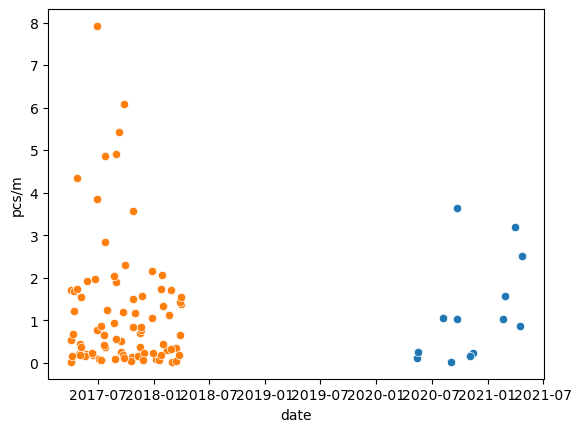

In [26]:
fig, ax = plt.subplots()

o_surveys = river_results['this_report'].sample_results
p_surveys = river_results['prior_report'] .sample_results

sns.scatterplot(data=o_surveys, x='date', y='pcs/m')
sns.scatterplot(data=p_surveys, x='date', y='pcs/m')
plt.show()

In [27]:
print(proportions)
r_most_common_objects

0.668918918918919


Object,Quantity,pcs/m,% of total,Fail rate
Diapers - wipes,117,"0,31","0,20","0,36"
Cigarette filters,108,"0,18","0,18","0,71"
Fragmented plastics,40,"0,07","0,07","0,64"
"Glass drink bottles, pieces",29,"0,05","0,05","0,36"
"Food wrappers; candy, snacks",23,"0,04","0,04","0,64"
Industrial sheeting,18,"0,03","0,03","0,29"
Tampons,17,"0,03","0,03","0,07"
Foam packaging/insulation/polyurethane,13,"0,01","0,02","0,21"
Packaging films nonfood or unknown,12,"0,02","0,02","0,36"
Expanded polystyrene,12,"0,02","0,02","0,07"


In [28]:
dx = river_results['this_report'].df
dx = dx[dx.code.isin(lmc_codes)]
dct = dx.groupby(['sample_id','city', 'code'], as_index=False).agg(session_config.unit_agg)
dct = dct.groupby(['city', 'code'], as_index=False).agg(session_config.agg_groups)
cities = dct.city.unique()

new_df = []
for city in cities:
    x = dct[dct.city == city][['city','code', 'pcs/m']]
    new_df.append(x)

i = pd.concat(new_df)
i.pivot(index='code', columns='city', values='pcs/m')

city,Bern,Biel/Bienne,Brügg,Burgdorf,Kallnach,Köniz,Port,Rubigen,Walperswil
code,,,,,,,,,
G112,0.0000,0.000,0.00,0.00,0.20,0.00,0.005,0.00,0.00
G200,0.0075,0.150,0.36,0.00,0.00,0.00,0.015,0.00,0.00
G25,0.0000,0.000,0.00,0.00,0.07,0.03,0.000,0.00,0.00
G27,0.0525,0.270,0.28,0.07,0.00,0.09,0.630,0.06,0.00
G30,0.0125,0.085,0.00,0.02,0.09,0.00,0.065,0.11,0.00
G67,0.0325,0.000,0.00,0.22,0.07,0.00,0.000,0.00,0.00
G74,0.0000,0.000,0.00,0.00,0.00,0.00,0.015,0.00,0.19
G89,0.0075,0.000,0.00,0.00,0.00,0.00,0.000,0.00,0.00
G904,0.0000,0.010,0.00,0.00,0.02,0.00,0.000,0.06,0.00


In [29]:
# collect the results from the prior and the likelihood
prr = river_results['prior_report'].sample_results.groupby('sample_id')['pcs/m'].sum()
lkl = river_results['this_report'].sample_results.groupby('sample_id')['pcs/m'].sum()

# consider all values
xii = river_results['posterior_no_limit'].sample_posterior()

# limit to the 99th percentile
sample_values, posterior, summary_simple = gfcast.dirichlet_posterior(river_results['posterior_99'])

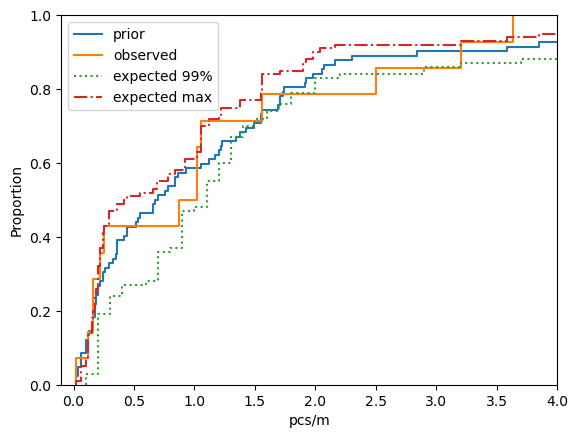

In [30]:
fig, ax = plt.subplots()

sns.ecdfplot(prr, label='prior', ls='-', ax=ax)
sns.ecdfplot(lkl, label='observed', ls='-', ax=ax)
sns.ecdfplot(sample_values, label='expected 99%', ls=':')
sns.ecdfplot(xii, label='expected max', ls='-.')
ax.set_xlim(-.1, 4)
ax.legend()
plt.show()